### TODO
- Factor out classes into .py-files to make notebook more concise
- Find package versions where we don't need to filter warnings (older packages)
- Set up pseudocode for the tournament;
    - players, saving models, etc.

In [14]:
# ignore deprecation warnings ('safe' as long as we don't update packages)
from warnings import filterwarnings
filterwarnings("ignore")

from math import sqrt, log, inf
import copy

import gym
from gym_go.gogame import turn, random_weighted_action, random_action

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from src.CNN import CNN, import_model, export_model
from src.MCTS import Monte_Carlo_Tree_Search

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BOARD_SIZE = 5

In [16]:
def play_game_no_render(mcts : Monte_Carlo_Tree_Search, go_env: gym.Env):
    go_env.reset()
    done = go_env.done
    turn_nr = 0
    while not done:
        action = random_action(go_env.state())
        _, _, done, _ = go_env.step(action)

        if done:
            continue

        node = mcts.get_move_from_env(go_env)
        _, _, done, _ = go_env.step(node.action)
        turn_nr += 1
        if turn_nr > 300:
            break
    
    return go_env

In [17]:
mcts_test = Monte_Carlo_Tree_Search(BOARD_SIZE, None)
_ = mcts_test.run_game()

In [18]:
for i in range(10):
    env = play_game_no_render(mcts_test, copy.deepcopy(mcts_test.env))
    if not env.done:
        print("Game stopped after 300 turns: \nIt was resigned and is a draw.")
        continue
        
    if env.reward() < 0:
        print("White won!")
    if env.reward() > 0:
        print("Black won!")
    if env.reward() == 0:
        print("It's a draw!")

White won!


KeyboardInterrupt: 

# Convolutional Neural Network

In [19]:
def train_model(model, lr, momentum):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    model.to(device)
    
    for epoch in range(10):
        mcts = Monte_Carlo_Tree_Search(BOARD_SIZE, model) # new tree
        mcts.run_game() # run a single game to completion
        x, y = mcts.get_tree_data() # get data
        running_loss = .0 
        for i in range(len(x)):
            inputs, labels = torch.tensor(x[i], device=device), torch.tensor(y[i], device=device)
            labels = F.softmax(labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if i % 10 == 9:
                print(f'[{epoch:3d}, {i + 1:3d}] loss: {running_loss / 10:.5f}')
                running_loss = 0.0

import time

def train(n_games=1000):
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Stats
    all_x, all_y, loss_values, acc_values = [], [], [], []
    total_time = 0

    # Simulate N games
    for _ in range(n_games):

        # Run a simulation and time it for statistics
        mcts = Monte_Carlo_Tree_Search(BOARD_SIZE, model)
        start = time.time()
        mcts.run_game()
        stop = time.time()
        total_time += (stop - start)

        game_loss = .0

        # Train model on data
        x, y = mcts.get_tree_data()
        for i in range(len(x)):
            inputs, labels = torch.tensor(x[i], device=device), torch.tensor(y[i], device=device)
            labels = F.softmax(labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            game_loss += loss.item()
            
            # Add data to master list for accuracy calculation
            all_x.append(x[i])
            all_y.append(y[i])
        
        # After training, check accuracy against previous data
        acc_values.append(model.avg_accuracy(all_x, all_y).item())
        loss_values.append(game_loss/len(x))

    print(f'''Finished running {n_games} games
    Time..............: {total_time}
    Avg. time per game: {total_time/n_games}''')
    return model, loss_values, acc_values


In [20]:
model, loss_values, acc_values = train(1000)

KeyboardInterrupt: 

[3.258183387203823, 3.257353039377346, 3.2553978168084465, 3.257621145147345, 3.257438591855839]
[0.03125, 0.1666666716337204, 0.16853933036327362, 0.19745223224163055, 0.1913580298423767]


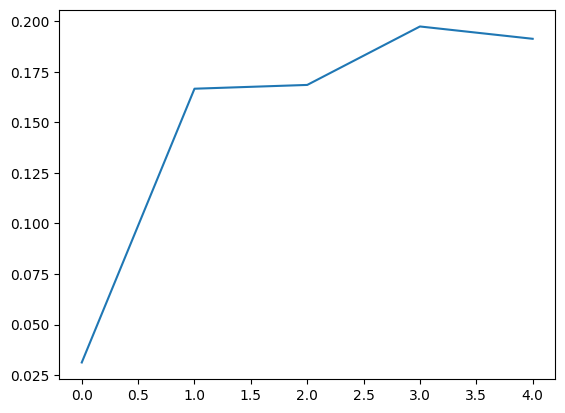

In [ ]:
plt.plot(acc_values)

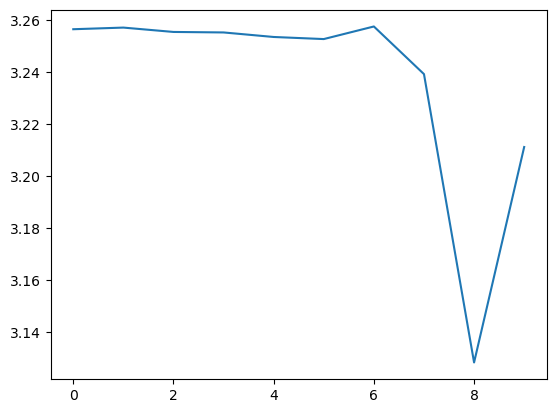

In [ ]:
plt.plot(loss_values)

# MCTS and CNN combined

1. Create an MCTS
2. Generate a lot of data from the MCTS
3. Use the data to train a CNN
4. Use the CNN in a new MCTS to hopefully make the MCTS make better choices
5. Generate new data with the new MCTS
6. Train a new CNN... repeat ad infinitum

In [ ]:
cnn = CNN()
# mcts = Monte_Carlo_Tree_Search(BOARD_SIZE, None)
# mcts.run(1000)
# x, y = mcts.get_tree_data()
# print("Datapoints: ", len(x))
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
# cnn.to(device)
# for i in range(len(x)):
#     inputs, labels = torch.tensor(x[i], device=device), torch.tensor(y[i], device=device)
#     labels = F.softmax(labels)
#     optimizer.zero_grad()
#     outputs = cnn(inputs)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()

# train_model(cnn, .01, .9)